# Wind Impact on PID Leashless Agent Performance

How robust is the PID without the safety leash to all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from trajectories import nasa_wp
from parameters import pid_params

In [2]:
best_agent = PIDAgent()

best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters': pid_params()}

In [3]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
triangle_wpts = np.array([[50,100,30], [-50, 100,30], [0,0,30]])


In [4]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [5]:
def toc(tte: np.ndarray):
    corridor = 2
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [6]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [7]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    wp = [(150,0,30)]
    env = env_selector.get_env("default", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    env.base_env.max_velocity = 10
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle,
                      other_vars=('reward', 'next_wp', 'wind', 'motor', 'vel'))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, wind=env.base_env.wind_x, motor=env.base_env.vehicle.speeds, vel=env.base_env.vehicle.velocity)

    log.done_logging()
    return log, info

In [16]:
log, info = run_trajectory(env_selector, [(0,0),(12,12),(0,0)], best_agent, best_params)

In [ ]:
def save_video_data(log, tte):
    X = log.x
    Y = log.y
    Z = log.z
    
    roll = log.roll
    pitch = log.pitch
    yaw = log.yaw
    
    wp_x = log.next_wp[:,0]
    wp_y = log.next_wp[:,1]
    wp_z = log.next_wp[:,2]
    
    data_array = np.vstack([X, Y, Z, roll, pitch, yaw, wp_x, wp_y, wp_z, tte]).T
    df = pd.DataFrame(data_array, columns=[['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw', 'WPX', 'WPY', 'WPZ', 'TTE']])
    df.to_csv('./data/sample_data.csv')

In [ ]:
save_video_data(log, get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

Text(0.5, 1.0, 'PID Wind Rejection')

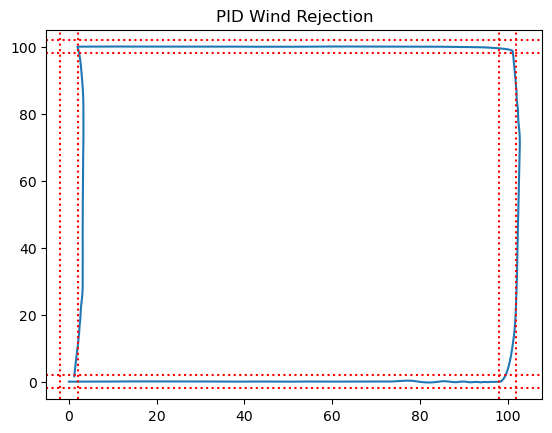

In [18]:
plt.plot(log.x, log.y)
# plt.xlim(90,110)
# plt.ylim(-10,10)
plt.axvline(x=98, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=102, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=-2, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=2, ymin=0, ymax=100, linestyle=':', color='red')

plt.axhline(y=98, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=102, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=-2, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=2, xmin=0, xmax=100, linestyle=':', color='red')
plt.title("PID Wind Rejection")

In [22]:
toc(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

19.39

In [24]:
len(log.t) / 100

105.79

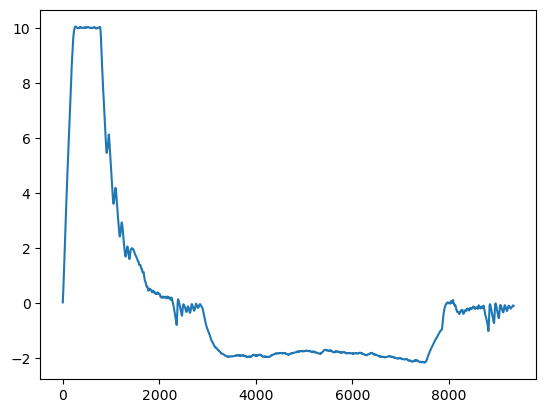

In [13]:
plt.plot(log.vel[:,0])

In [10]:
max(log.velocity[:,0])

9.276061

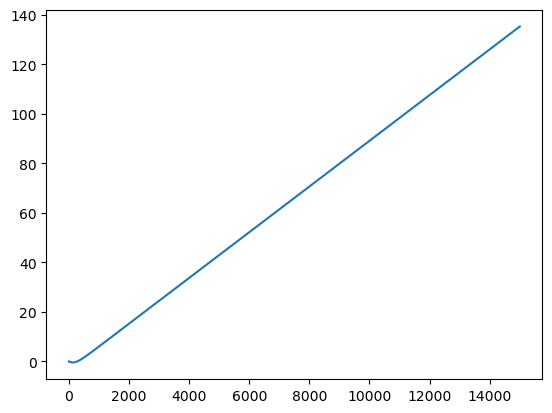

In [26]:
plt.plot(log.x)

In [36]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    'n7': [(0,0), (7,7), (0,0)],
    'n10': [(0,0), (10,10), (0,0)],
    'n12': [(0,0), (12,12), (0,0)],
    's5': [(0,0), (-5,-5), (0,0)],
    's7': [(0,0), (-7,-7), (0,0)],
    's10': [(0,0), (-10,-10), (0,0)],
    's12': [(0,0), (-12,-12), (0,0)],
    'e5': [(5,5), (0,0), (0,0)],
    'e7': [(7,7), (0,0), (0,0)],
    'e10': [(10,10), (0,0), (0,0)],
    'e12': [(12,12), (0,0), (0,0)],
    'w5': [(-5,-5), (0,0), (0,0)],
    'w7': [(-7,-7), (0,0), (0,0)],
    'w10': [(-10,-10), (0,0), (0,0)],
    'w12': [(-12,-12), (0,0), (0,0)],
    'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
}

In [37]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [38]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(env_selector, wind_dict[wind], agent, params)
        traj_err = get_tte(np.array([0,0,30]), log.next_wp, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [39]:
wind_results = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_2502476/755085242.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
100%|██████████| 4/4 [01:33<00:00, 23.31s/it]


In [30]:
wind_results.to_csv('./data/pid_noleash_wind.csv')

In [31]:
wind_results = pd.read_csv('./data/pid_noleash_wind.csv') 

In [40]:
wind_results

,Wind,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,n12,1.067458e+06,71.159104,False,-215991.562500,148.59
1,s12,1.327908e+06,88.521326,False,-268081.687500,148.59
2,e12,7.226930e+02,0.048176,False,-2644.538818,0.00
3,w12,1.032537e+06,63.795951,False,-206506.546875,148.26


In [41]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  nan
Std reward for 5 m/s:  nan
Mean reward for 7 m/s:  nan
Std reward for 7 m/s:  nan
Mean reward for 10 m/s:  nan
Std reward for 10 m/s:  nan


In [42]:
print("Mean for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Mean for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Mean for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())
print("Mean for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].mean())
print("Std for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].std())


Mean for 5 m/s:  nan
Std for 5 m/s:  nan
Mean for 7 m/s:  nan
Std for 7 m/s:  nan
Mean for 10 m/s:  nan
Std for 10 m/s:  nan
Mean for 12 m/s:  55.88113926430746
Std for 12 m/s:  38.63833150433512


In [35]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].std())
print("Mean reward for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].mean())
print("Std reward for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].std())

Mean reward for 5 m/s:  9.09375
Std reward for 5 m/s:  0.9442750431642559
Mean reward for 7 m/s:  10.942499999999999
Std reward for 7 m/s:  1.9119604747857257
Mean reward for 10 m/s:  20.55875
Std reward for 10 m/s:  4.285411923857829
Mean reward for 12 m/s:  24.810000000000002
Std reward for 12 m/s:  2.772219327542464


In [19]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].std())

Mean reward for 5 m/s:  1.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  1.0
Std reward for 10 m/s:  0.0
